In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Dense, Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import sys
np.set_printoptions(threshold=sys.maxsize)


# data


In [3]:
df=pd.read_csv('/Users/vedantgupta/Documents/summer project/data-analysis-with-technical-indicators-2/nifty_sensex_close_data/data/M&M.NS_2011_to_2023.csv')


In [4]:

def make_dataset(df,w):
    
    l=int(len(df))
    n=int(0.8*(l-w))

    #for close price
    df_close=df['M&M.NS_close']
    df_close = df_close.astype(float)
    data_i=np.zeros((l-w,w))

    for i in range (l-w):
        for j in range(w):
            data_i[i][j]=df_close[i+j]

    data_o=np.array([df_close[i+w] for i in range(l-w)])
    data_o=data_o.reshape(l-w,1)

    data=np.column_stack((data_i,data_o))

    #training and validating data
    tv_data=data[:n,:]
    np.random.seed(0)
    np.random.shuffle(tv_data)

    #test data
    test_data=data[n:,:-1]
    act_data=data[n:,-1]
    
    return tv_data,test_data,act_data

In [5]:
#splitting the dataset into training and valdation

def split_dataset(ran_tv_close):
    
    X_close=ran_tv_close[:,:-1]
    y_close=ran_tv_close[:,-1]
    X_train_close, X_val_close, y_train_close, y_val_close = train_test_split(X_close, y_close, test_size=0.2, random_state=0)

    return X_train_close, X_val_close, y_train_close, y_val_close


In [6]:
tv_data,test_data,act_data=make_dataset(df,25)
X_train_close, X_val_close, y_train_close, y_val_close=split_dataset(tv_data)

X_train_close.shape, X_val_close.shape, y_train_close.shape, y_val_close.shape, test_data.shape, act_data.shape

((2034, 25), (509, 25), (2034,), (509,), (636, 25), (636,))

# model


In [7]:
initalizer2 = keras.initializers.HeNormal

tf.keras.backend.clear_session()

In [8]:
w=25
def model_builder(hp):
  model = keras.Sequential()
  act = hp.Choice('activation', values=['relu','sigmoid', 'tanh'])
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hl = hp.Int('layers', min_value=2, max_value=6, step=1)
  model.add(Dense(hp_units, input_shape=(w,), activation=act, name = 'Input'))
  for i in range(hl):
    model.add(Dense(units=hp_units, activation=act))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse',metrics=['mape'] )
  return model

In [9]:
tuner = kt.Hyperband(model_builder, objective=kt.Objective("val_mape", direction="min"), max_epochs=10, factor=3, directory='ki', project_name='intro_to_kt')


Reloading Tuner from ki/intro_to_kt/tuner0.json


In [10]:
tuner.search(X_train_close,y_train_close, epochs=100, batch_size=25, validation_data=(X_val_close,y_val_close))
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model=tuner.hypermodel.build(best_hps)
print(model.summary())

history=model.fit(X_train_close, y_train_close, epochs=100, batch_size=25, validation_data=(X_val_close,y_val_close))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-12 21:13:30.760478: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-12 21:13:30.760575: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-12 21:13:30.760593: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-12 21:13:30.760689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-12 21:13:30.760755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (Dense)                   │ (None, 480)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 480)            │       230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 480)            │       230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 480)            │       230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 480)            │       230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 480)            │       230,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,167,361 (4.45 MB)

 Trainable params: 1,167,361 (4.45 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


2024-06-12 21:13:31.474896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 60664.8984 - mape: 30.3443 - val_loss: 862.3454 - val_mape: 3.9448
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 723.9219 - mape: 3.8526 - val_loss: 604.3134 - val_mape: 3.3281
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 482.6234 - mape: 3.1515 - val_loss: 364.3970 - val_mape: 2.6058
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 387.5156 - mape: 2.7032 - val_loss: 395.1546 - val_mape: 2.9000
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 325.7785 - mape: 2.4724 - val_loss: 217.5031 - val_mape: 2.0789
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 268.8238 - mape: 2.2818 - val_loss: 259.6780 - val_mape: 2.3512
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 247.0165 - mape: 2.2414 - val_loss: 172.5009 - val_mape: 1.8508
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 224.2960 - mape: 2.1036 - val_loss: 186.8687 - val_mape: 1.9185
Epoch 9/100
82/82

In [11]:
test_pred=model.predict(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [12]:
#save model

model.save('model_best.keras')

In [13]:


#mae and accuracy for test data
def mae_accuracy_test(y_pred_close,act_data):

    mae_close = np.mean(abs(y_pred_close - act_data))

    return mae_close

In [14]:
act_data=act_data.reshape(len(act_data),1)

mae=mae_accuracy_test(test_pred,act_data)
print('mae_test=',mae)

#r2 score for test data
from sklearn.metrics import r2_score
r2=r2_score(act_data,test_pred)
print('r2_test=',r2)

#mape for test data
mape_=np.mean(np.abs((act_data - test_pred) / act_data)) * 100
print('mape_test=',mape_)

#accuracy for test data
acc_test=1-(mae/np.mean(act_data))
print("Accuracy_test=",acc_test)

#root mean square error for test data
from sklearn.metrics import mean_squared_error
rmse_test=np.sqrt(mean_squared_error(act_data,test_pred))
print('rmse_test=',rmse_test)


mae_test= 14.607058447112077
r2_test= 0.9954993636952707
mape_test= 1.3144384969457417
Accuracy_test= 0.9871524973132614
rmse_test= 19.62886796466814


# plotting


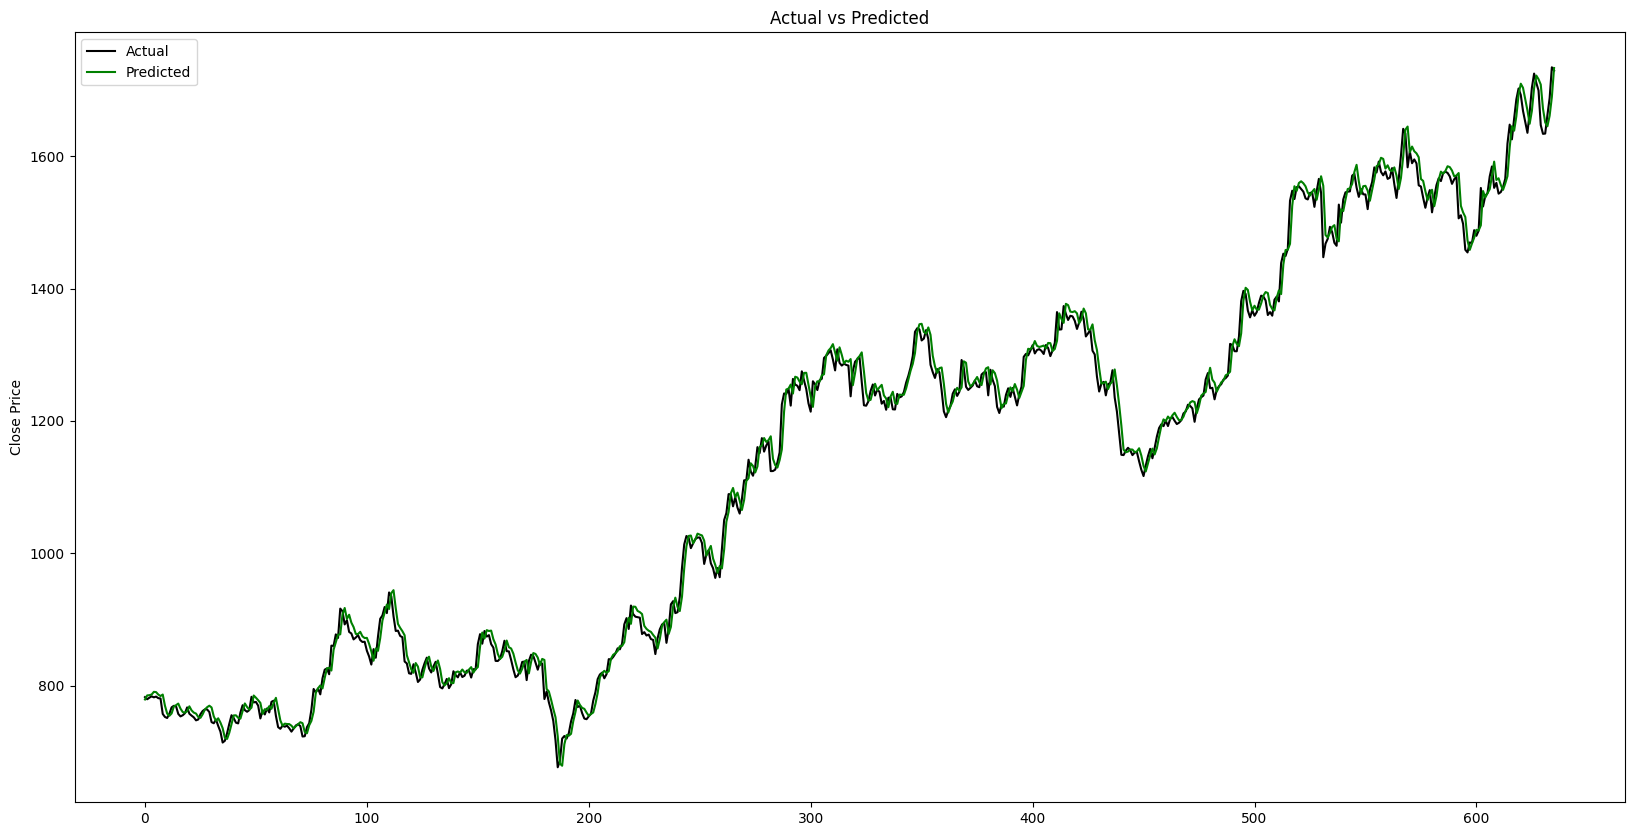

In [15]:
#plot actual vs predicted for test data

plt.figure(figsize=(20,10))
plt.plot(act_data, color = 'black', label = 'Actual')
plt.plot(test_pred, color = 'green', label = 'Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Close Price')
plt.legend()
plt.show()

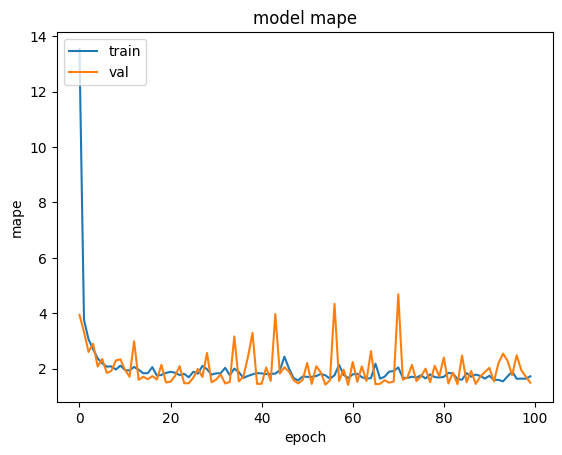

In [16]:
#plot epochs vs mape
plt.plot(history.history['mape'], label='mape')
plt.plot(history.history['val_mape'], label='val_mape')
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [17]:
act_data.shape

(636, 1)

In [18]:
test_pred.shape

(636, 1)

In [19]:
a=int(len(df))
b=int(0.8*(a-w))
y=b+w

df1=df['M&M.NS_close']
df_numpy=df1.to_numpy()
new_data=df_numpy[y-1:a-1]
new_data=new_data.reshape(len(new_data),1)

In [20]:
new_data.shape

(636, 1)

In [21]:
new_data.shape

(636, 1)

In [22]:
bs=test_pred-new_data
bs
#profit and loss    
def profit_loss(bs):
    n=len(bs)
    profit=0
    loss=0
    for i in range(n-1):
        if bs[i]>0:
            profit=profit+bs[i]
        else:
            loss=loss-bs[i]
    return profit,loss

profit,loss =profit_loss(bs)
profit_factor=profit/loss

print('profit=',profit)
print('loss=',loss)

print('profit=',profit-loss)
print('profit_factor=',profit_factor)



profit= [3741.49224854]
loss= [175.57006836]
profit= [3565.92218018]
profit_factor= [21.31053592]


In [23]:
signal=np.array([])

for i in range(len(bs)):
    if bs[i]>0:
        signal=np.append(signal,1)
    else:
        signal=np.append(signal,-1)

signal.reshape(len(signal),1)
df_out = df[['Date', 'M&M.NS_close']]
df_out_arr = df_out.to_numpy()
trading_signal = np.column_stack((df_out_arr[y:],signal))
trading_signal_df = pd.DataFrame(trading_signal, columns=['Date', 'Close Price', 'Trading Signal'])
trading_signal_df

,Date,Close Price,Trading Signal
0,2021-06-08,782.566345,1.0
1,2021-06-09,779.272766,1.0
2,2021-06-10,781.694519,1.0
3,2021-06-11,783.680359,1.0
4,2021-06-14,782.178833,1.0
...,...,...,...
631,2023-12-22,1634.25,1.0
632,2023-12-26,1662.25,1.0
633,2023-12-27,1687.949951,-1.0
634,2023-12-28,1734.449951,1.0


In [24]:
trading_signal_df['Date']=pd.to_datetime(trading_signal_df['Date'])
trading_signal_df['Close Price']=trading_signal_df['Close Price'].astype(float)
trading_signal_df['Trading Signal']=trading_signal_df['Trading Signal'].astype(float)

trading_signal_df.dtypes


Date              datetime64[ns]
Close Price              float64
Trading Signal           float64
dtype: object

In [26]:
trading_signal_df.to_csv('/Users/vedantgupta/Documents/summer project/data-analysis-with-technical-indicators-2/nifty_sensex_close_data/data/trading_signal_nn_mm.csv',index=False)